# A Variational Auto Encoder 

## 0. Preprocessing

Import the libraries we will use.

In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math

import dataset_loader

%matplotlib inline

Next, we download and preprocess the MNIST dataset, see http://yann.lecun.com/exdb/mnist/ .
Our observed random variables will be Bernoulli distributions, so we need to binarize the dataset, i.e. each pixel can either be black or white.

In [2]:
mnist_path = ".../mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(train_data_pixels, train_data_classes), \
(dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

In [3]:
# to binarize, we just set to 1 pixels with a value >= 0.5, 0 otherwise
train_data_pixels = 1*(train_data_pixels >= 0.5)
dev_data_pixels = 1*(dev_data_pixels >= 0.5)

In [4]:
# dataset_loader return numpy tensors,
# we convert them directly to pytorch tensors
train_data_pixels = torch.from_numpy(train_data_pixels).float()
train_data_classes = torch.from_numpy(train_data_classes).long()

dev_data_pixels = torch.from_numpy(dev_data_pixels).float()
dev_data_classes = torch.from_numpy(dev_data_classes).long()

In [5]:
# there 50000 images, each image is of size 28x28
# each image as been reshaped as vector of size 784
print("Shape of the pixel tensor:", train_data_pixels.shape)
print("Shape of the class tensor:", train_data_classes.shape)

Shape of the pixel tensor: torch.Size([50000, 784])
Shape of the class tensor: torch.Size([50000])


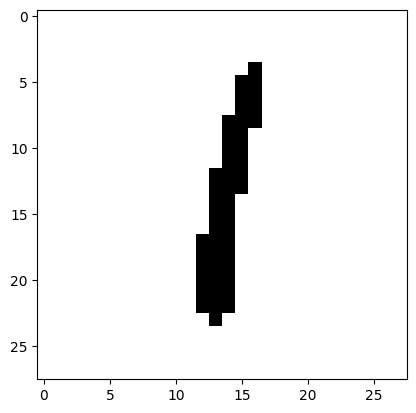

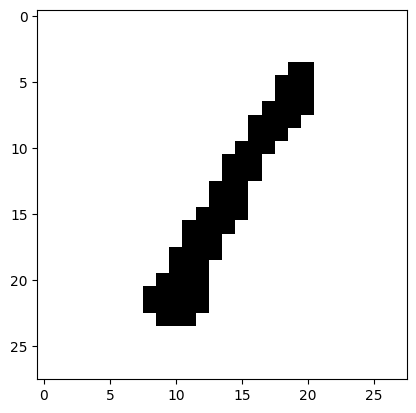

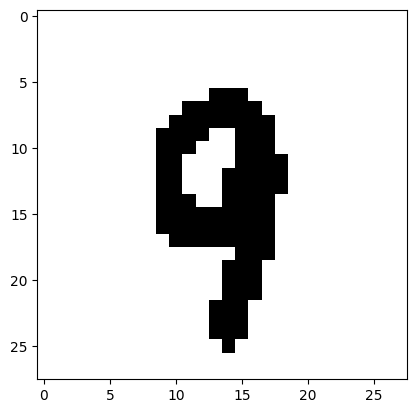

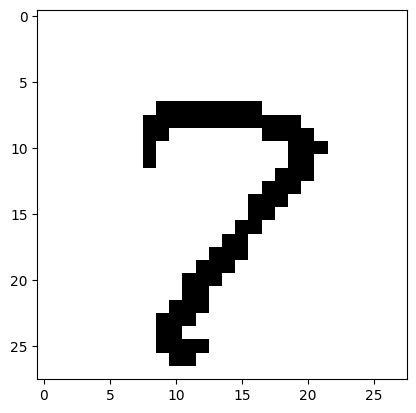

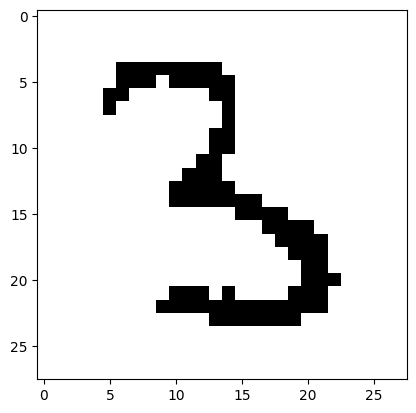

In [6]:
# we will use this function to print images generated by our network
# the parameter images must be a tensor of shape (n images, 784)
def display_images(images):
    # convert to numpy tensor
    images = images.detach().numpy()

    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='Greys')
        plt.show()
        
# display the 5 first image in the dataset
display_images(train_data_pixels[:5])

## 1. MNIST classification with Pytorch

In [7]:
# we create a class that extends nn.Module
class Classifier(nn.Module):
    # input_dim: in our case it will the size of a single input image
    # hidden_dim: the hidden representation dim
    # output_dim: the number of class, in our case there are 10 digits
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_ratio=0.5):
        super().__init__()
        
        # we have two projections in the network,
        # the first one project the input in the hidden space,
        # the second one project the hidden representation in the output space.
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
        # dropout can be used to prevent overfitting,
        # however, it may be better to start training VAE without!
        self.dropout = nn.Dropout(0.5)
        
    # this is the function that will be called
    # when we pass data to the network to compute the output
    # shape of batch: (n samples, output_dim)
    # where n samples is the number of samples in the batch
    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        # note: dropout is used to prevent overfitting
        hid = self.dropout(hid)
        
        # return the output, i.e. logits of each class for each sample in the batch
        # shape: (n samples, output_dim)
        return self.proj2(hid)

In [8]:
n_epoch = 20
batch_size = 100

# build the network!
network = Classifier(28*28, 200, 10)
optimizer = torch.optim.Adam(network.parameters())

all_epoch_losses = list()
all_epoch_accuracies = list()
for epoch in range(n_epoch):
    epoch_loss = 0
    network.train()
    
    for i in range(0, train_data_pixels.shape[0], batch_size):
        optimizer.zero_grad()
        
        # batch of data
        # shape: (n samples, 784)
        batch = train_data_pixels[i:i+batch_size]
        
        # compute the weights associate with each class for each picture
        # logits shape: (n samples, 10)
        logits = network(batch)
        
        # compute the loss
        loss = F.cross_entropy(
            logits,
            train_data_classes[i:i+batch_size],
            reduction="mean"
        )
        
        epoch_loss += loss.item() * batch.shape[0]
        
        loss.backward() # compute the gradient
        optimizer.step() # update parameters of the model
        
    # at the end of each epoch, we eval on the dev data
    network.eval()
    n_dev_correct = 0
    with torch.no_grad():
        for i in range(0, dev_data_pixels.shape[0], batch_size):
            batch = dev_data_pixels[i:i+batch_size]
            logits = network(batch)

            pred = logits.argmax(1)
            n_dev_correct += (pred == dev_data_classes[i:i+batch_size]).sum().item()
    
    all_epoch_losses.append(epoch_loss)
    all_epoch_accuracies.append(n_dev_correct / dev_data_classes.shape[0]) 
    print(
        epoch, ":\t",
        epoch_loss,# / len(train_data[0]),
        "\t / dev precision:\t",
        n_dev_correct / dev_data_classes.shape[0],
        flush=True
    )

0 :	 24607.91113227606 	 / dev precision:	 0.9367
1 :	 12559.53263938427 	 / dev precision:	 0.9553
2 :	 9700.709961354733 	 / dev precision:	 0.9626
3 :	 8018.180572614074 	 / dev precision:	 0.9656
4 :	 7010.512609779835 	 / dev precision:	 0.9697
5 :	 6291.551335155964 	 / dev precision:	 0.972
6 :	 5691.129007935524 	 / dev precision:	 0.9718
7 :	 5276.462030783296 	 / dev precision:	 0.9712
8 :	 4719.318572804332 	 / dev precision:	 0.9733
9 :	 4519.223473779857 	 / dev precision:	 0.9734
10 :	 4178.008413128555 	 / dev precision:	 0.9747
11 :	 3839.517262764275 	 / dev precision:	 0.9755
12 :	 3780.9956163167953 	 / dev precision:	 0.9754
13 :	 3483.656828571111 	 / dev precision:	 0.9746
14 :	 3162.263756804168 	 / dev precision:	 0.9762
15 :	 3252.2099426947534 	 / dev precision:	 0.9749
16 :	 2988.1313796155155 	 / dev precision:	 0.9754
17 :	 2885.0856326520443 	 / dev precision:	 0.976
18 :	 2780.843964824453 	 / dev precision:	 0.9763
19 :	 2612.5952602829784 	 / dev precis

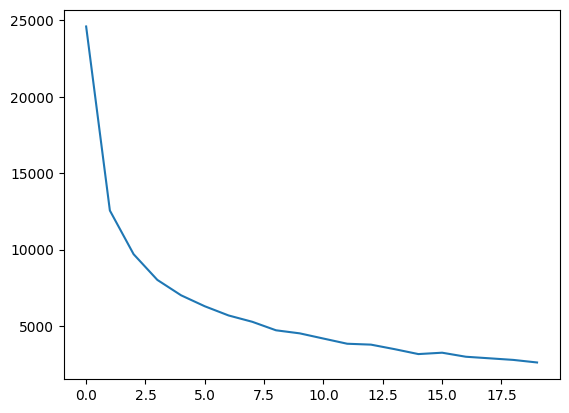

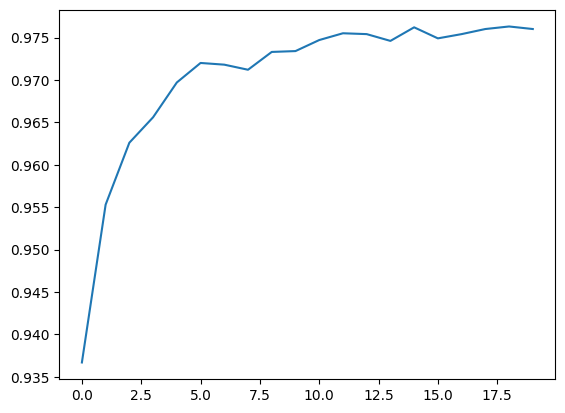

In [10]:
# print graph to show how the loss and the accuracy evolve during training,
# for example to see if we overfit the training data.
# Note that MNIST is a really simple dataset, so its no really interesting in this case :)
plt.plot(np.arange(n_epoch), all_epoch_losses)
plt.show()

plt.plot(np.arange(n_epoch), all_epoch_accuracies)
plt.show()

## 2. VAE with continuous latent space and binary observed space

The first VAE that we will develop is based on the following generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

where the latent random variable $Z$ takes value in $\mathbb R^n$.
The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent.
Fix the mean and variance of each coordinate to 0 and 1, respectively.
The conditional distribution $p(x | z ; \theta)$ is parameterized by a neural network.
The random variables $X$ are $m$ independent Bernoulli random variables.

### KL divergence

The first function we have to implement is the one that compute the KL divergence with the prior.

In [11]:
# the shapes of mu and log_sigma_squared are: (n batch, n latent)
# the return vector must be of shape: (n batch,)
def KL_with_gaussian_prior(mu, log_sigma_squared):
    temp = torch.ones(mu.size(dim=0), mu.size(dim=1)) + log_sigma_squared \
           - torch.pow(mu, 2) - torch.exp(log_sigma_squared)
    return -0.5*torch.sum(temp, axis = 1)
    
# test for shape
mu = torch.rand((10, 30))
log_sigma_squared = torch.rand((10, 30))

if KL_with_gaussian_prior(mu, log_sigma_squared).shape != (10, ):
    raise RuntimeError("Invalid return dim!")
else:
    print("return dim is ok.")
    
# test for return value
# result should be 0 as it is equal to the prior
print("Should be 0:", KL_with_gaussian_prior(torch.tensor([[0.]]), torch.tensor([[0.]])).item())
print("Should be 0.5:", KL_with_gaussian_prior(torch.tensor([[1.]]), torch.tensor([[0.]])).item())
print("Should be 2.6945...:", KL_with_gaussian_prior(torch.tensor([[1.]]), torch.tensor([[2.]])).item())

return dim is ok.
Should be 0: -0.0
Should be 0.5: 0.5
Should be 2.6945...: 2.694528102874756


### Network

The encoder should return a tuple of tensors (mu, log_sigma_squared),
both are unconstrained so they should be the output of a linear projection.
The term log_sigma_squared means that the standard deviation can be computed via sigma=exp(0.5 * log_sigma_squared).

The structure of the encoder should be as follow:

- one projection and non linearity (e.g. relu) to compute a hidden representation of the input,
- two projections to compute my and log_sigma_squared from the same hidden representation.

The structure of the decoder shoud be similar to the classifier above.
Similarly to the encoder, the decoder should output unconstrained value, i.e. it does not directly return the mu parameters of the Bernoulli distribution, but values in R.

- one projection and non linearity (e.g. relu) to compute a hidden representation of the input,
- one projection to the output space

The decode has two additional functions:

- sample_distributions: it samples from the prior and return the conditional output distributions
- sample_images: call sample_distributions and then sample images from the output distributions.

This second function change a tensor in-place (hence the _ at the end of the name)

In [12]:
class GaussianEncoder(nn.Module):
    # input_dim: in our case it will the size of a single input image
    # hidden_dim: the hidden representation dim
    # output_dim: the number of class, in our case there are 10 digits
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        #linear projection from input space to hidden space
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        
        #linear projection from hidden space to mean and variance
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        self.proj3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        
        # deterministic non-linear vectorspace
        hidden = self.proj1(batch)
        hidden = F.relu(hidden)
        
        # Transform inte a gaussian latent space given by mu, exp(0.5*log_sigma_squared)
        mu = self.proj2(hidden) 
        log_sigma_squared = self.proj3(hidden)
        
        # return the parameters to the approximate posterior
        return (mu, log_sigma_squared)    

In [13]:
class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        self.input_dim = input_dim 

        super().__init__()
        
        # input_dim = latent_dim | hidden_dim = hidden_dim | output_dim = output_dim
        
        # linear projection from latent dim to hidden_dim
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        
        # linear projection from hidden dim to output dim
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        
        # non-linear projection of the batch to the hidden data
        hidden = F.relu(self.proj1(batch))
        
        #linear projection from hidden to output
        return self.proj2(hidden)

    # n_samples: number of "image output distribution" to compute
    def sample_distributions(self, n_samples):
        # first sample from the prior,
        # then pass the data through this network, i.e. self(z)
        
        # shape of z: (n_samples, input_dim)
        z = torch.empty((n_samples, self.input_dim)).normal_(mean=0, std=1)
        
        # shape of decoded: (n_samples, output_dim)
        decoded = self(z)
        decoded = torch.sigmoid(decoded)

        return decoded
    
        # sample images
    def sample_images(self, n_samples, argmax=False):
        # compute the output distributions for each image
        # probs shape: (n_samples, output_dim)
        probs = self.sample_distributions(n_samples)
        if argmax == False:
            # returns a bernulli given the probability distr.
            return torch.bernoulli(probs)
        elif argmax == True:
            #return the most probabel value for each pixel
            return (1 * (probs >= 0.5))
        else:
            return None
        
        


### Training loop

Notice the reparameterization trick!

In [14]:

dim_input = 28*28
latent_dim = 2 # we use only 2 dimensions so we can plot them!
hidden_dim = 400
n_epoch = 20
batch_dim = 256

encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim]
        
        # compute parameters of the approximate posterior
        # mu, log_sigma_square have size batchdim, latent_dim (col1 = x1 mean, col2 = x2 mean)
        mu, log_sigma_squared = encoder(batch)
        
        # for MC sampling of the reconstruction loss,
        # we use one sample from the approximate posterior.
        # use the reparameterization trick
        # enables us to backpropagate the whole thing stright up using reparametrization
        
        sigma = torch.exp(0.5 * log_sigma_squared)
        eps = torch.empty_like(mu).normal_(mean=0., std=1.)
        
        # batch_dim points are sampled from the respective 2D gaussians
        # using reparametrization trick
        z = mu + sigma * eps
        
        # reconstruction_logits: (batches, classes, output size)
        # note that the output of the network is in R,
        # to get Bernoulli parameters use the sigmoid.
        reconstruction_logits = decoder(z)
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        )
        
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)
        
        # loss shape: (batch dim,)
        elbo = -reconstruction_loss.sum(1) - kl_div
        
        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        # we want to maximize the ELBO,
        # but Pytorch does minimization,
        # so we define our loss as -ELBO
        loss = -elbo.mean()
        loss.backward()
        
        # gradient clipping, so we don't take too big updates
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        optimizer.step()
        
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0]
    )

0 :	 -193.558487578125 	 6.041566353287696
1 :	 -161.257342890625 	 5.021513151855468
2 :	 -156.5916266015625 	 5.1579795373535156
3 :	 -154.4133421484375 	 5.259411838378906
4 :	 -152.8434885546875 	 5.361824265136719
5 :	 -151.5448258203125 	 5.455239763793945
6 :	 -150.413676328125 	 5.532033127441406
7 :	 -149.34242845703125 	 5.6104469122314455
8 :	 -148.46478970703126 	 5.657349321289063
9 :	 -147.636469921875 	 5.708648251342773
10 :	 -146.88234765625 	 5.774759140625
11 :	 -146.19933333984375 	 5.801456207275391
12 :	 -145.54866173828125 	 5.863564024658203
13 :	 -144.981816171875 	 5.895274444580078
14 :	 -144.4153483984375 	 5.934934515991211
15 :	 -143.94027134765625 	 5.95883052734375
16 :	 -143.4784046875 	 6.015433610839843
17 :	 -143.0053497265625 	 6.028616853027343
18 :	 -142.6262335546875 	 6.04885026977539
19 :	 -142.19966994140626 	 6.0887954193115235


We can now visualize the output distribution from random prior samples and generate new images.

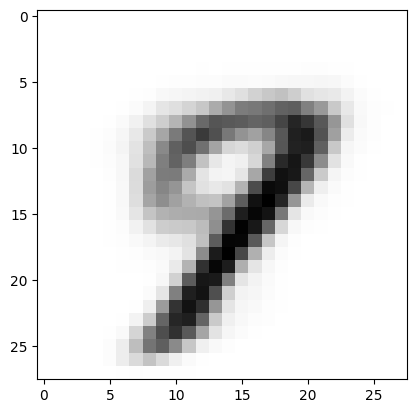

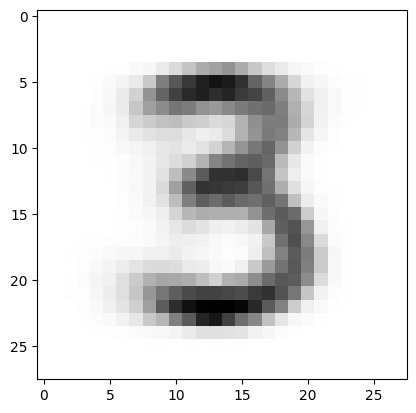

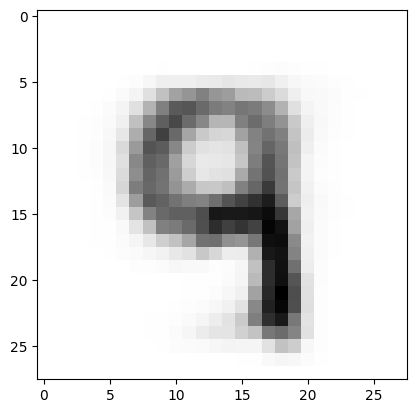

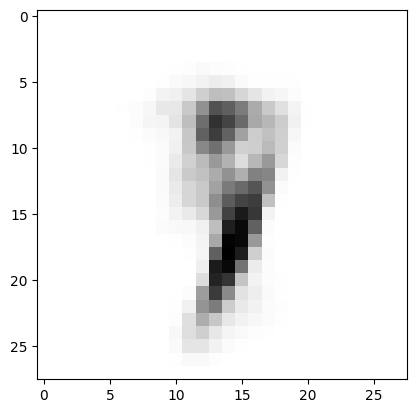

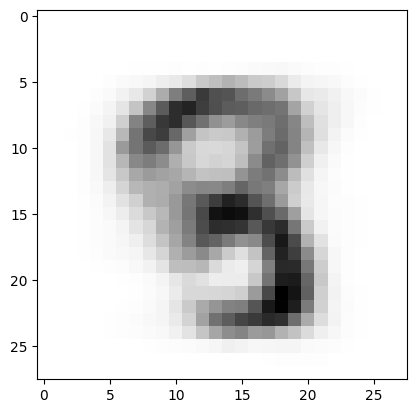

In [15]:
decoder.eval()

with torch.no_grad():
    samples = decoder.sample_distributions(5)
    display_images(samples)

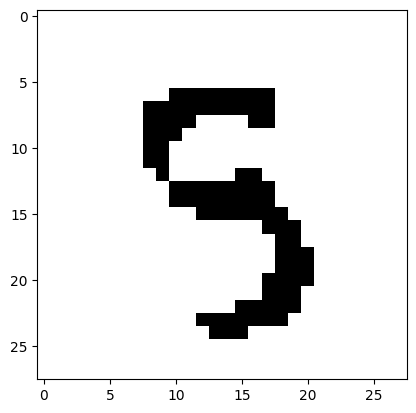

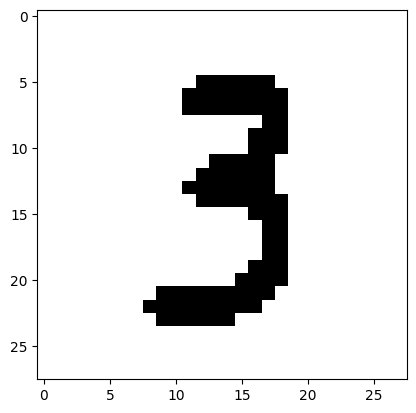

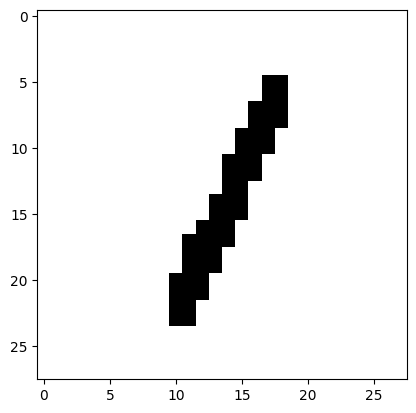

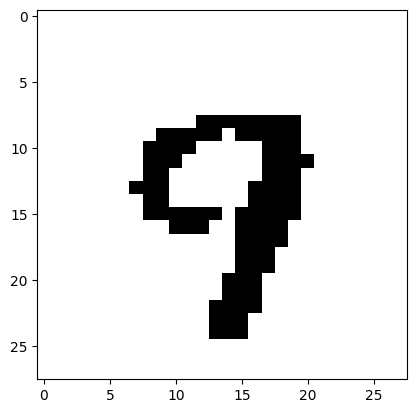

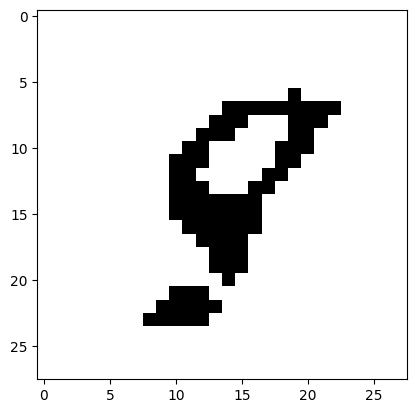

In [13]:
decoder.eval()

with torch.no_grad():
    samples = decoder.sample_images(5, argmax=True)
    display_images(samples)

Using the approximate posterior, we can visualize the latent space, by assigning one color per digit.
What we display is the mean value.
For a well trained model, we should see all points close to 0 and each class should be well delimited, i.e. there must be clusters of the same color.

Note that if you want to visualize a latent space when its dimension is greater than two, you could project it in 2 dimensions using PCA

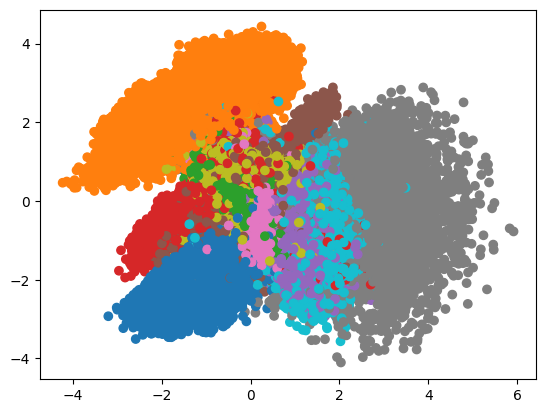

In [41]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        mu, _ = encoder(batch)
        points[i:i+batch_dim] = mu.numpy()

plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
)
plt.show()

# 4. Turning a Deterministic Auto-Encoder into a generative model

This a two step process.

First, train an auto-encoder - not a VAE, just an encoder.
The encoder takes an image and project it in the latent space, here we will use a 2 dimension latent space.
It is a deterministic computation: the output of the encoder is not the parameters of the approximate posterior $q(z|x)$ distribution, it is a point in the $\mathbb R^2$ space.
The decoder reconstruct the input image from the encoder output.
Therefore, during training, the main difference is that you don't have a KL divergence term!

Second, we turn this deterministic model into a probabilistic generative model.
To do this, we look at where each training image of the training is mapped in the latent space.
Gaussian Mixture Model that will generate data that look like the latent space of the training set!
Then, to generate a new data point:

1. sample a cluster from the GMM: $y \sim p(y)$
2. sample a point from the bivariate Gaussian associated with this cluster: $z \sim p(z|y)$
3. use the decoder to sample an image: $x \sim p(x | z)$
